In [1]:
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import os
import re

In [2]:
urls = {
    "Business Standard": "https://www.business-standard.com",
    "LiveMint": "https://www.livemint.com",
    "Economic Times": "https://economictimes.indiatimes.com",
    "Moneycontrol": "https://www.moneycontrol.com"
}

In [3]:

results = []
num_runs = 5
os.makedirs("performance", exist_ok=True)


In [4]:
for name, url in urls.items():
    perf_scores, seo_scores = [], []
    page_sizes = []
    fcps, ttis, speed_indices, tbts, clss = [], [], [], [], []

    for i in range(num_runs):
        out_file = f"performance/{name.lower().replace(' ', '_')}_{i}.json"
        subprocess.run([
            "npx", "lighthouse", url,
            "--output=json", f"--output-path={out_file}",
            "--only-categories=performance,seo",
            "--disable-device-emulation",
            "--disable-throttling",
            "--quiet", "--chrome-flags=--headless"
        ])

        with open(out_file) as f:
            report = json.load(f)
            perf_scores.append(report['categories']['performance']['score'] * 100)
            seo_scores.append(report['categories']['seo']['score'] * 100)

            page_size_str = report['audits']['total-byte-weight']['displayValue']
            page_size_val = re.findall(r'\d+', page_size_str)
            page_size_val = float(''.join(page_size_val))
            # match = re.search(r'([\d,]+)\s*KiB', page_size_str)
            # if match:
            #     page_size_val = float(match.group(1).replace(',', ''))
            #     page_sizes.append(page_size_val)
            page_sizes.append(page_size_val)

            fcps.append(float(report['audits']['first-contentful-paint']['displayValue'].replace('s', '').strip()) * 1000)
            ttis.append(float(report['audits']['interactive']['displayValue'].replace('s', '').strip()) * 1000)
            speed_indices.append(float(report['audits']['speed-index']['displayValue'].replace('s', '').strip()) * 1000)

            tbts_str = report['audits']['total-blocking-time']['displayValue'].replace('ms', '').strip()
            tbts_val = re.findall(r'\d+', tbts_str)
            tbts_val = float(''.join(tbts_val))
            tbts.append(tbts_val)
            
            clss.append(float(report['audits']['cumulative-layout-shift']['displayValue'].strip()))

    results.append({
        "Site": name,
        "Performance Score": round(mean(perf_scores), 2),
        "SEO Score": round(mean(seo_scores), 2),
        "Avg Page Size (KiB)": round(mean(page_sizes), 2),
        "First Contentful Paint (ms)": round(mean(fcps), 2),
        "Time to Interactive (ms)": round(mean(ttis), 2),
        "Speed Index (ms)": round(mean(speed_indices), 2),
        "Total Blocking Time (ms)": round(mean(tbts), 2),
        "Cumulative Layout Shift": round(mean(clss), 3)
    })

LanternError: Invalid dependency graph created, cycle detected
    at PageDependencyGraph.createGraph (file:///home/mush/.npm-global/lib/node_modules/lighthouse/node_modules/@paulirish/trace_engine/models/trace/lantern/graph/PageDependencyGraph.js:481:19)
    at Module.createGraph (file:///home/mush/.npm-global/lib/node_modules/lighthouse/node_modules/@paulirish/trace_engine/models/trace/LanternComputationData.js:366:46)
    at #createLanternContext (file:///home/mush/.npm-global/lib/node_modules/lighthouse/node_modules/@paulirish/trace_engine/models/trace/Processor.js:255:46)
    at #computeInsightsForNavigation (file:///home/mush/.npm-global/lib/node_modules/lighthouse/node_modules/@paulirish/trace_engine/models/trace/Processor.js:481:49)
    at #computeInsights (file:///home/mush/.npm-global/lib/node_modules/lighthouse/node_modules/@paulirish/trace_engine/models/trace/Processor.js:440:47)
    at TraceProcessor.parse (file:///home/mush/.npm-global/lib/node_modules/lighthouse/node_mod

In [5]:
df = pd.DataFrame(results)
print(df)

                Site  Performance Score  SEO Score  Avg Page Size (KiB)  \
0  Business Standard               58.6       83.0               2225.2   
1           LiveMint               60.8       92.0               2066.4   
2     Economic Times               34.0       83.4              10899.0   
3       Moneycontrol               21.2       75.0               6904.8   

   First Contentful Paint (ms)  Time to Interactive (ms)  Speed Index (ms)  \
0                       1440.0                   18840.0            4300.0   
1                       1980.0                   21560.0            8540.0   
2                       5660.0                   53900.0           30340.0   
3                       3160.0                   57040.0           13300.0   

   Total Blocking Time (ms)  Cumulative Layout Shift  
0                    1448.0                    0.040  
1                    1188.0                    0.012  
2                    2250.0                    0.052  
3            

In [6]:
metrics = [
    "Performance Score",
    "SEO Score",
    "First Contentful Paint (ms)",
    "Time to Interactive (ms)",
    "Speed Index (ms)",
    "Total Blocking Time (ms)",
    "Cumulative Layout Shift"
]

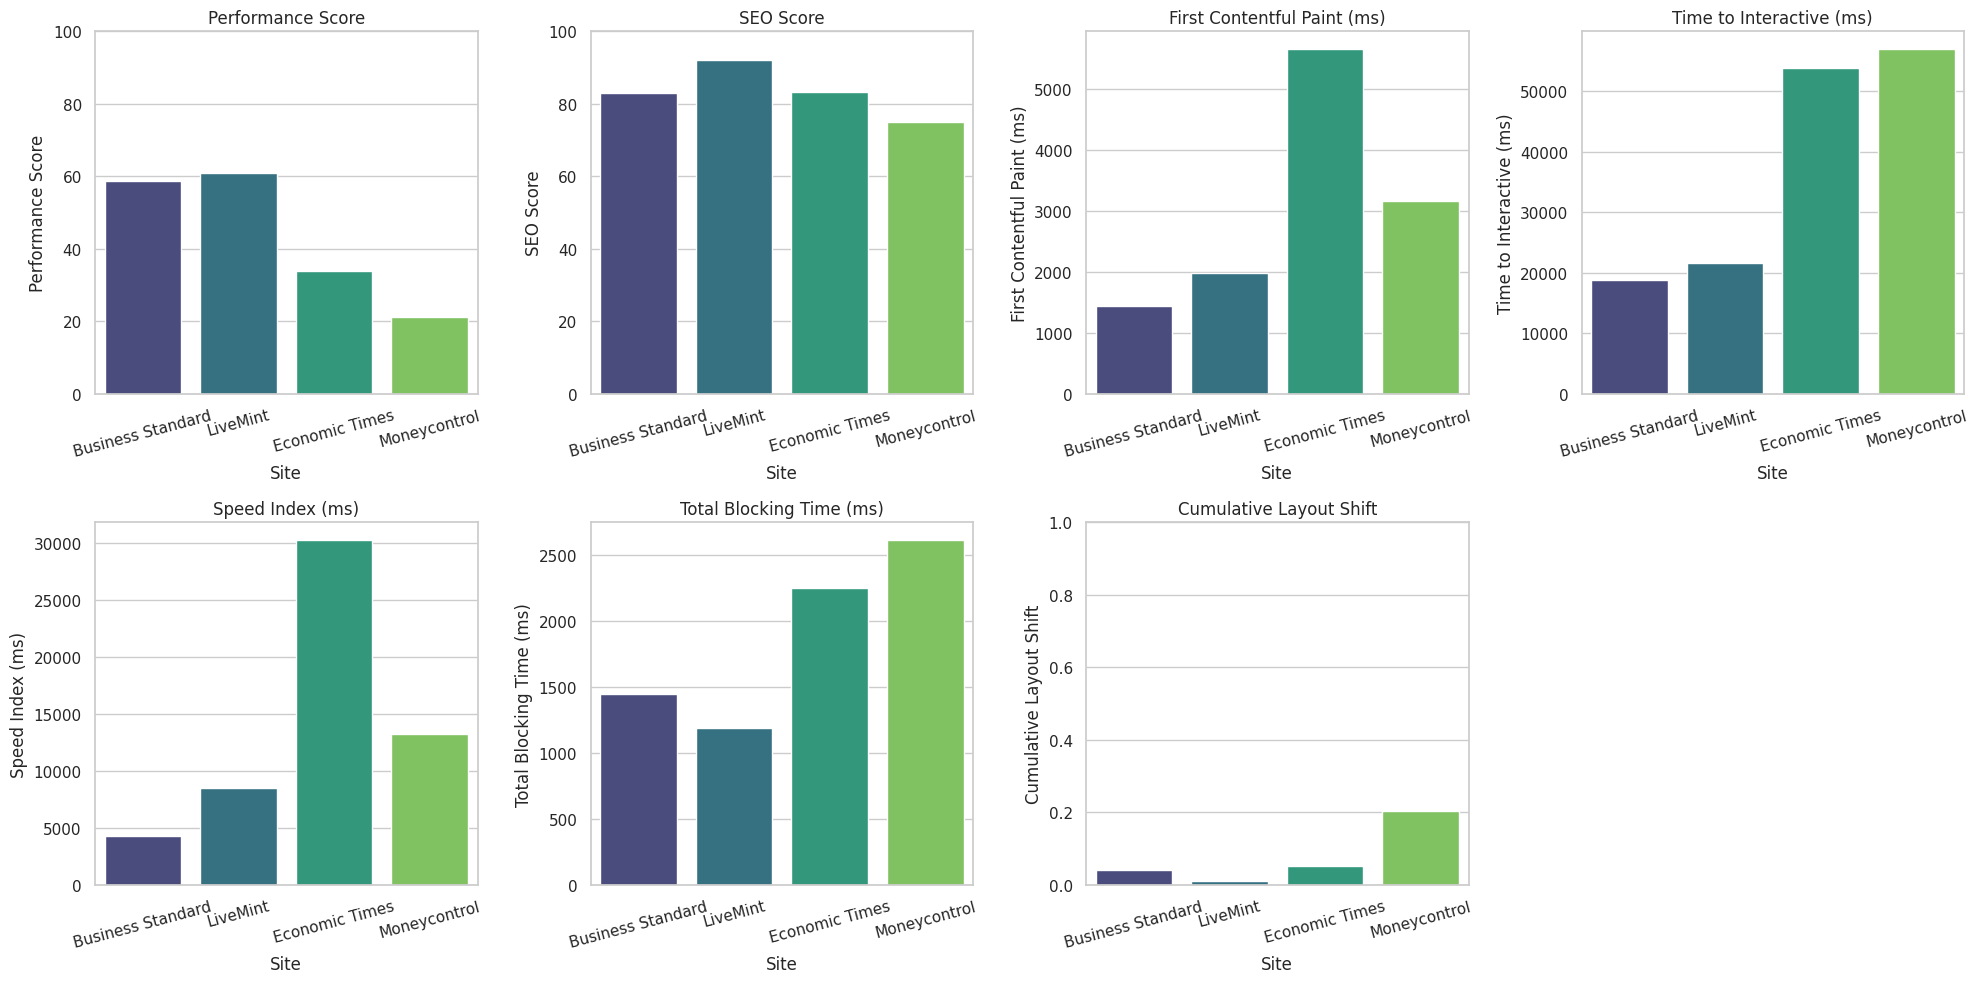

In [7]:
# Visualization
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(data=df, x="Site", y=metric, ax=axs[i], palette="viridis", hue="Site", legend=False)
    axs[i].set_title(metric)
    axs[i].tick_params(axis='x', rotation=15)
    if "Score" in metric:
        axs[i].set_ylim(0, 100)
    elif "Cumulative Layout Shift" in metric:
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(0, None)

fig.delaxes(axs[-1])  # Remove last empty subplot
plt.tight_layout()
plt.show()

| **Metric**                | **What it Measures**                 | **High/Low Better** | **How Calculated**                                |
|---------------------------|--------------------------------------|---------------------|---------------------------------------------------|
| **Performance Score**     | Overall speed & responsiveness       | High                | Weighted aggregate of performance metrics         |
| **SEO Score**             | SEO best practices compliance        | High                | Automated SEO checks (meta tags, links, etc.)     |
| **First Contentful Paint**| Time to first visible content         | Low                 | Browser paint timing events                       |
| **Time to Interactive**   | Time until page is fully interactive | Low                 | Main thread idle detection                        |
| **Speed Index**           | Visual completeness speed            | Low                 | Video frame visual progress analysis              |
| **Total Blocking Time**   | Time main thread is blocked          | Low                 | Sum of long main thread tasks (>50ms)             |
| **Cumulative Layout Shift**| Visual layout stability             | Low                 | Sum of unexpected layout shifts                   |
